In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import itertools
import numpy
import nltk
import matplotlib.pyplot
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
import pandas
import seaborn
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import re as regularExpression
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

nltk.download('stopwords')
hermesDataDirectoryFolder = '/kaggle/input/fake-and-real-news-dataset/'
mercuryDataDirectoryFolder = '/kaggle/input/fake-news/'

stopwords = set(nltk.corpus.stopwords.words('english'))

trueDataNews = pandas.read_csv(hermesDataDirectoryFolder + 'True.csv')
falseDataNews = pandas.read_csv(hermesDataDirectoryFolder + 'Fake.csv')
falseMercuryDataNews = pandas.read_csv(mercuryDataDirectoryFolder + 'fake.csv')
englishMercuryDataNews = falseMercuryDataNews.loc[(falseMercuryDataNews['language'] == 'english') & (falseMercuryDataNews['title'].notna())]

trueDataNews['class'] = 1
falseDataNews['class'] = 0
allNewsData = pandas.concat([trueDataNews, falseDataNews])

/kaggle/input/fake-news/fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
trueDataNews.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [109]:
trueDataNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   class    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [110]:
falseDataNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   class    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [111]:
englishMercuryDataNews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11723 entries, 0 to 12912
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                11723 non-null  object 
 1   ord_in_thread       11723 non-null  int64  
 2   author              9514 non-null   object 
 3   published           11723 non-null  object 
 4   title               11723 non-null  object 
 5   text                11677 non-null  object 
 6   language            11723 non-null  object 
 7   crawled             11723 non-null  object 
 8   site_url            11723 non-null  object 
 9   country             11547 non-null  object 
 10  domain_rank         7662 non-null   float64
 11  thread_title        11723 non-null  object 
 12  spam_score          11723 non-null  float64
 13  main_img_url        8286 non-null   object 
 14  replies_count       11723 non-null  int64  
 15  participants_count  11723 non-null  int64  
 16  like

# Helper News data

In [2]:
def intersectNewsSubjects(lhsData, rhsData):
    return numpy.intersect1d(lhsData.subject.unique(), rhsData.subject.unique())

def removeNoisyData(data, numberOfWords):
    corpus = []
    for i in range(0, numberOfWords):
        document = regularExpression.sub('[^a-zA-Z]', ' ', data[i])
      #  document = document.lower()
        document = document.split()
        porterStemmer = PorterStemmer()
        document = [porterStemmer.stem(word) for word in document if not word in set(stopwords)]
        document = ' '.join(document) 
        corpus.append(document)
    return corpus

def transformClassify(transformer, classifier, classfierTransformerName):
    numberOfWords = len(allNewsData['title'].values)
    corpus = removeNoisyData(allNewsData['title'].values, numberOfWords)
    X = transformer.fit_transform(corpus).toarray()
    y = allNewsData['class'].values[:numberOfWords]
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)
    # crossValueScoreResult = cross_val_score(classifier, xTrain, yTrain, cv=3, n_jobs=6)
    predictionTrainY = cross_val_predict(classifier, xTrain, yTrain, cv=3, n_jobs=6)
    classifier.fit(xTrain, yTrain)
    predictTestY = classifier.predict(xTest)
    
    plotClassifierResult(yTrain, predictionTrainY, allNewsData['class'].unique(), confusionMatrixTitle="Hermes-Train" + classfierTransformerName)
    plotClassifierResult(yTest, predictTestY, allNewsData['class'].unique(), confusionMatrixTitle="Hermes-Test" + classfierTransformerName)

    mercuryCorpus = removeNoisyData(englishMercuryDataNews['title'].values, len(englishMercuryDataNews['title'].values))
    X_MercuryCorpus = transformer.fit_transform(mercuryCorpus).toarray()

    mercuryPrediction = classifier.predict(X_MercuryCorpus)
    zeros = numpy.zeros(len(X_MercuryCorpus))
    plotClassifierResult(zeros, mercuryPrediction, numpy.flip(allNewsData['class'].unique()), confusionMatrixTitle="Mercury" + classfierTransformerName)

# Helper Visualizer functions

In [3]:

def plotAllDataNews():
    matplotlib.pyplot.close()
    seaborn.countplot(allNewsData, x='class')
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject', hue='class', data=allNewsData, linewidth=10)
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotFalseNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject',  data=falseDataNews, linewidth=10)
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotTrueNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject',  data=trueDataNews, linewidth=10)
    matplotlib.pyplot.show()

def plot_confusion_matrix(correctTargetValues, estimatedTargetValues, classes, bNormalizeConfusionMatrix=False, title='Confusion Matrix', colourMap=matplotlib.pyplot.cm.Blues, figureSize=(9,7)):
    matrix = confusion_matrix(correctTargetValues, estimatedTargetValues)

    if bNormalizeConfusionMatrix:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, numpy.newaxis]
    
    matplotlib.pyplot.close()
    matplotlib.pyplot.imshow(matrix, interpolation='nearest', cmap=colourMap)
    matplotlib.pyplot.title(title)

    tickMarks = numpy.arange(len(classes))
    matplotlib.pyplot.xticks(tickMarks, classes, rotation=45)
    matplotlib.pyplot.yticks(tickMarks, classes)

    fmt= '.2f' if bNormalizeConfusionMatrix else 'd'
    threshold = matrix.max() / 2.0
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        matplotlib.pyplot.text(j, i, format(matrix[i,j], fmt),
            horizontalalignment='center',
            size=int((figureSize[0] / 10) * 38),
            color='white' if matrix[i,j] > threshold else 'black')
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.ylabel('True label')
    matplotlib.pyplot.xlabel('Predicted lable')
    matplotlib.pyplot.show()
    
def plotClassifierResult(yExpected, yPredicted, classes, confusionMatrixTitle="Confusion Matrix"):
    print(accuracy_score(yExpected, yPredicted))
    plot_confusion_matrix(yExpected, yPredicted, classes=classes, title=confusionMatrixTitle)
    plot_confusion_matrix(yExpected, yPredicted, classes=classes, bNormalizeConfusionMatrix=True, )


0.9656698244884626


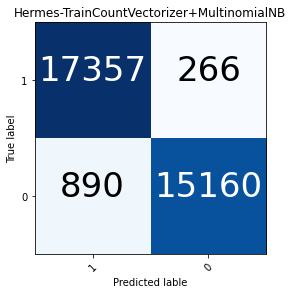

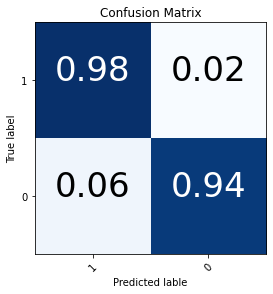

0.968195991091314


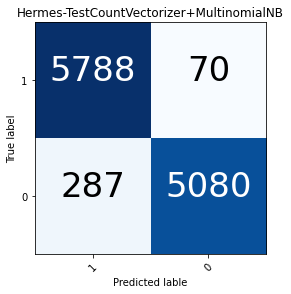

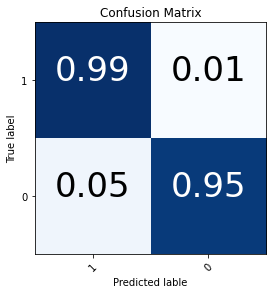

0.6813102448178794


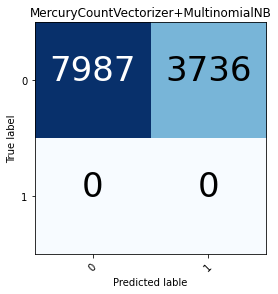

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


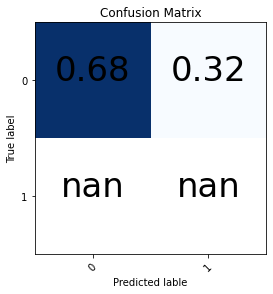

In [114]:
countVectorizer = CountVectorizer(max_features=10000)
classifier = MultinomialNB(alpha=0.01)
transformClassify(countVectorizer, classifier, "CountVectorizer+MultinomialNB")

0.965224363733555


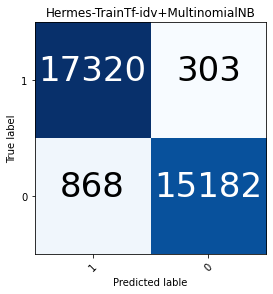

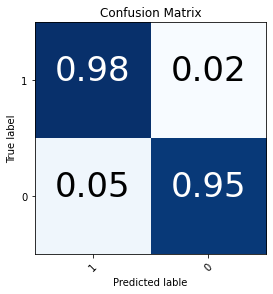

0.9694432071269488


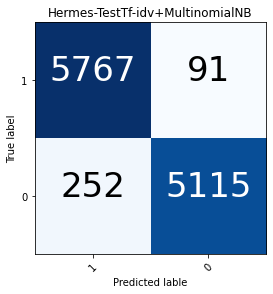

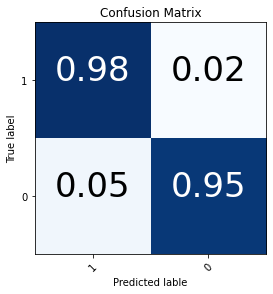

0.8472234069777361


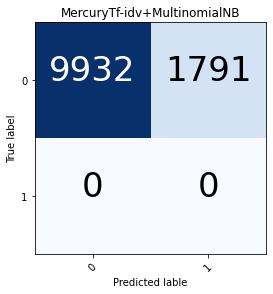

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


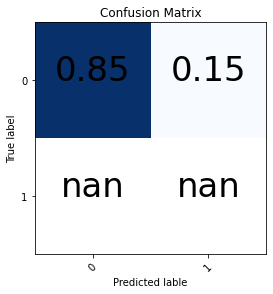

In [115]:
countVectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3), lowercase=False)
classifier = MultinomialNB(alpha=0.01)
transformClassify(countVectorizer, classifier, "Tf-idv+MultinomialNB")

# Test round up on the Tf-idv + MultinomialNB

(1000, (1, 1), False, None, 2, 1.0, 0.001)
0.9554539245092507


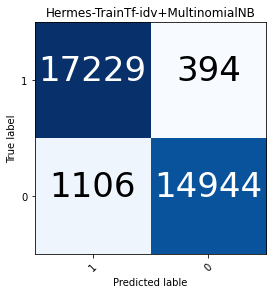

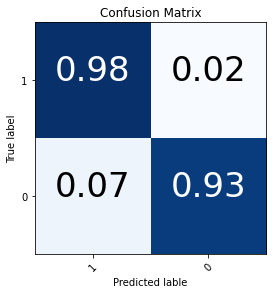

0.9579510022271714


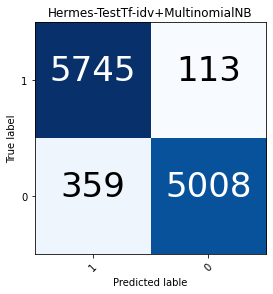

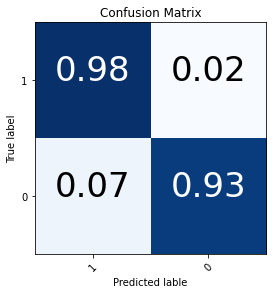

0.687452017401689


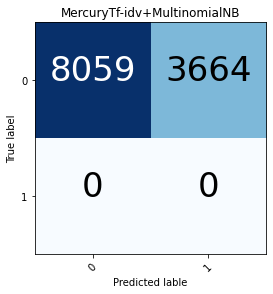

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


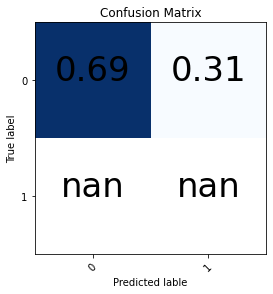

(1000, (1, 1), False, None, 2, 1.0, 0.01)
0.9555727140438928


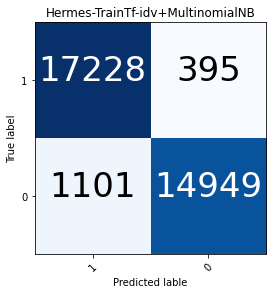

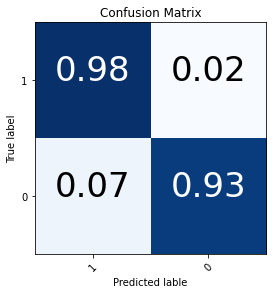

0.9581291759465479


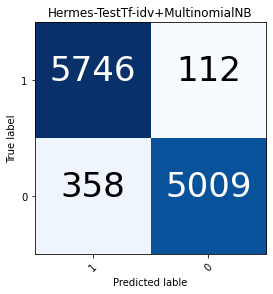

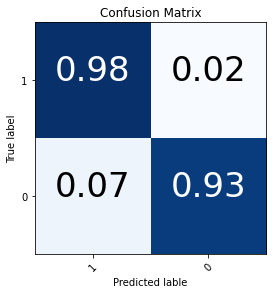

0.6879638317836732


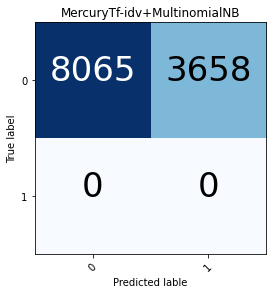

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


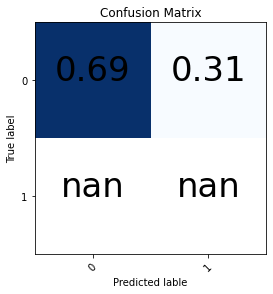

(1000, (1, 1), False, None, 2, 1.0, 0.02)
0.9555727140438928


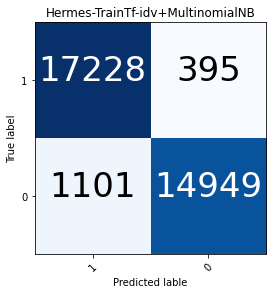

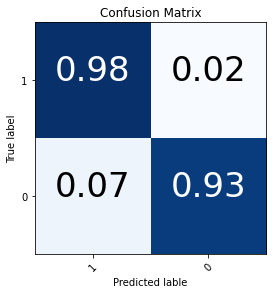

0.9581291759465479


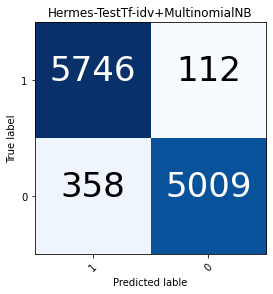

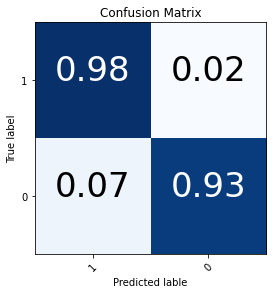

0.6883903437686599


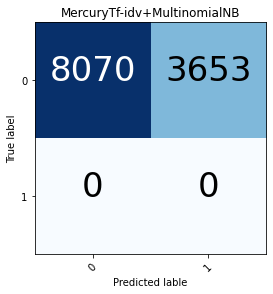

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


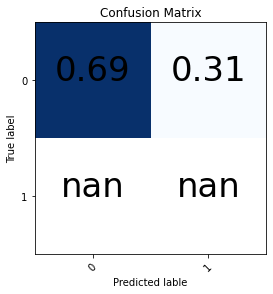

(1000, (1, 1), False, None, 2, 1.0, 0.05)
0.9556024114275532


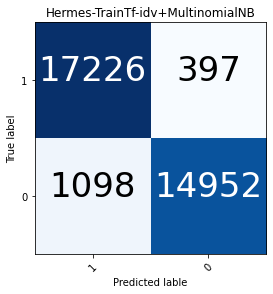

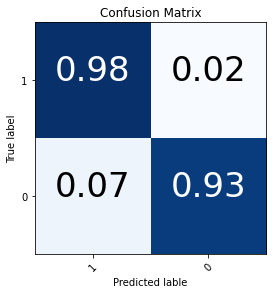

0.9581291759465479


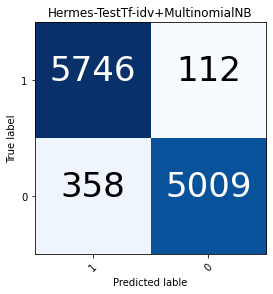

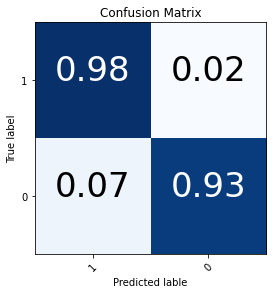

0.6883050413716626


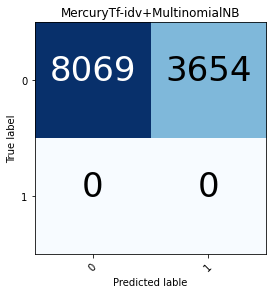

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


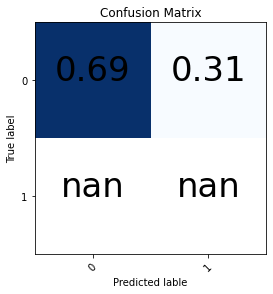

(1000, (1, 1), False, None, 2, 1.0, 0.075)
0.9556321088112137


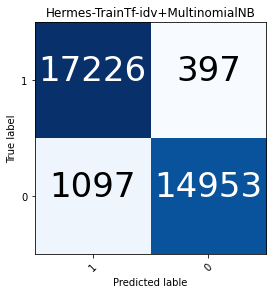

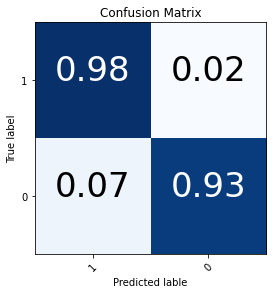

0.9579510022271714


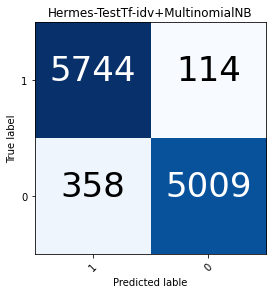

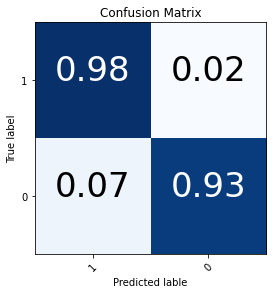

0.6872814126076943


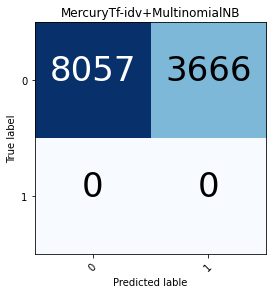

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


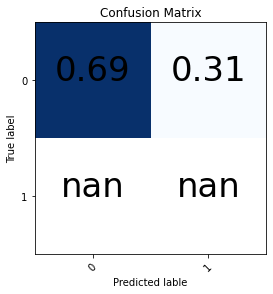

(1000, (1, 1), False, None, 2, 1.0, 0.1)
0.9556321088112137


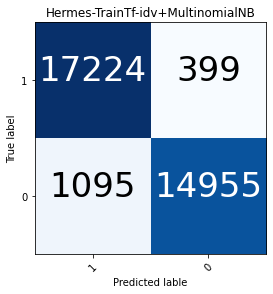

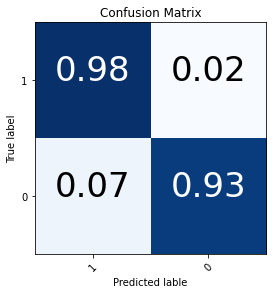

0.9580400890868597


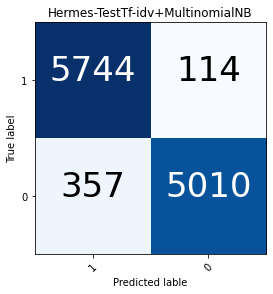

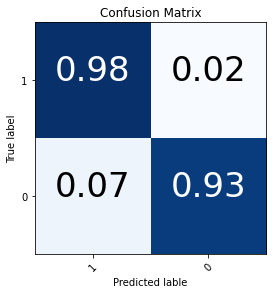

0.6863430862407234


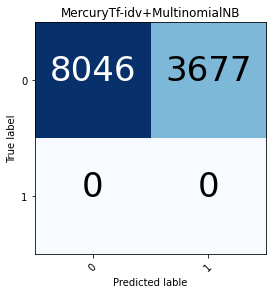

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


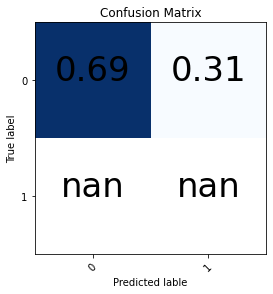

(1000, (1, 1), False, None, 2, 1.0, 0.5)
0.9558102931131768


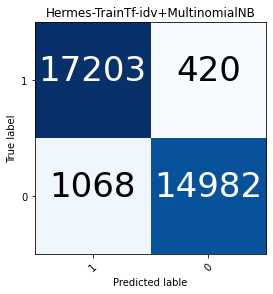

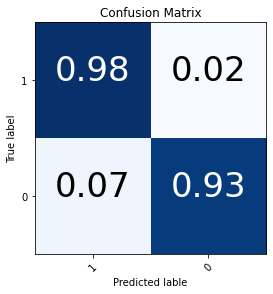

0.9580400890868597


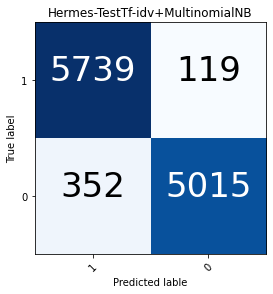

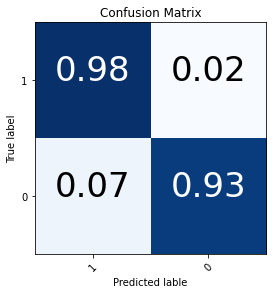

0.6746566578520856


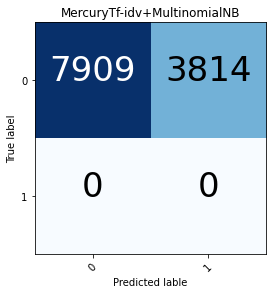

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


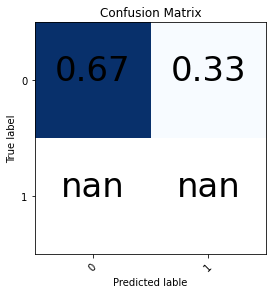

(1000, (1, 1), False, None, 2, 0.7, 0.001)
0.9554539245092507


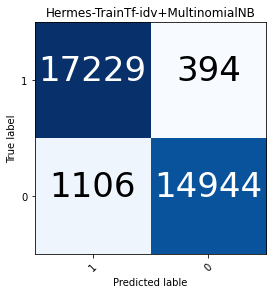

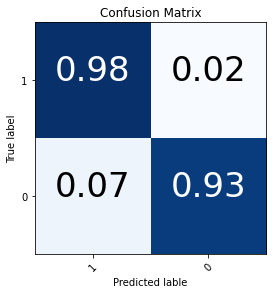

0.9579510022271714


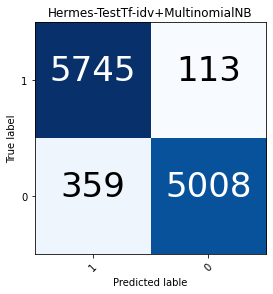

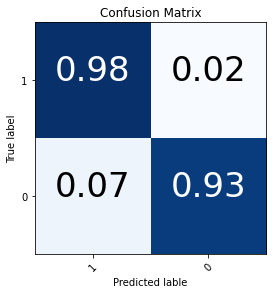

0.687452017401689


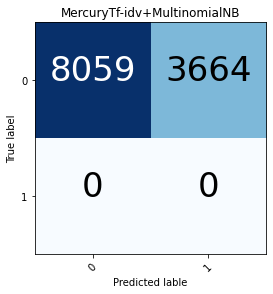

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


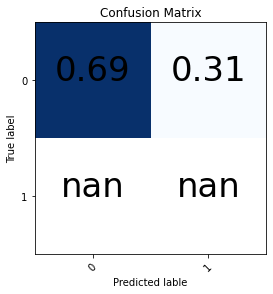

(1000, (1, 1), False, None, 2, 0.7, 0.01)
0.9555727140438928


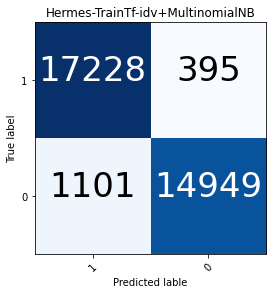

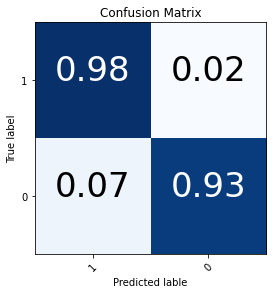

0.9581291759465479


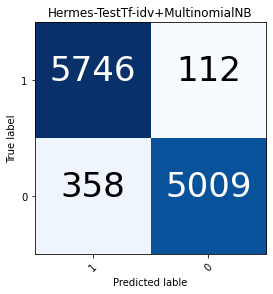

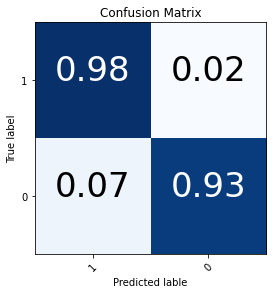

0.6879638317836732


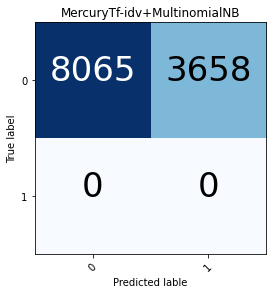

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


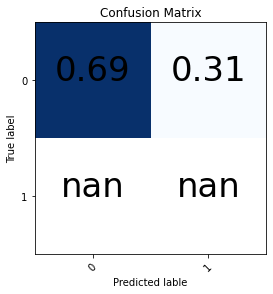

(1000, (1, 1), False, None, 2, 0.7, 0.02)
0.9555727140438928


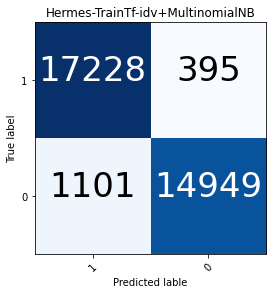

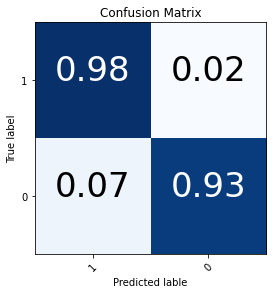

0.9581291759465479


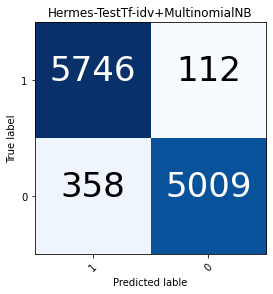

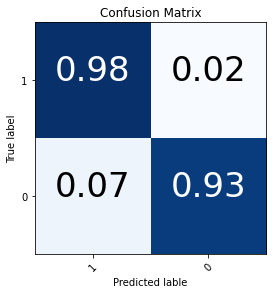

0.6883903437686599


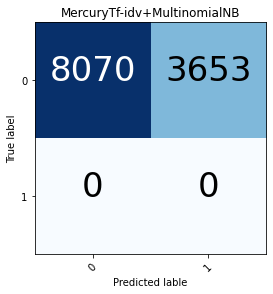

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


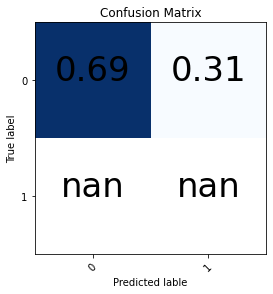

(1000, (1, 1), False, None, 2, 0.7, 0.05)
0.9556024114275532


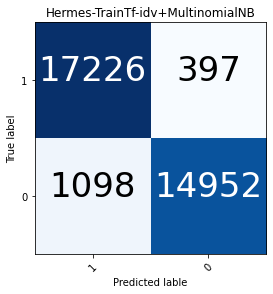

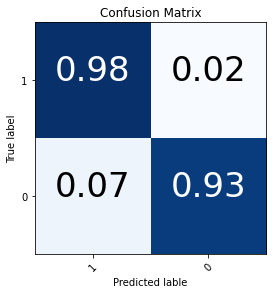

0.9581291759465479


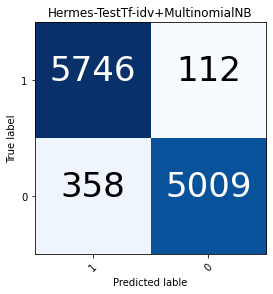

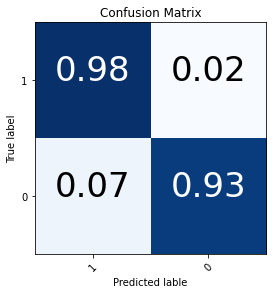

0.6883050413716626


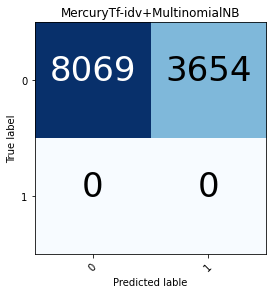

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


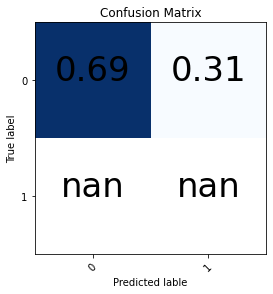

(1000, (1, 1), False, None, 2, 0.7, 0.075)
0.9556321088112137


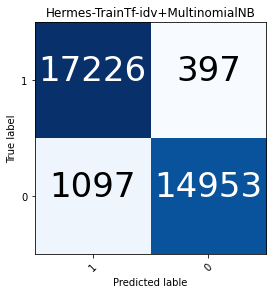

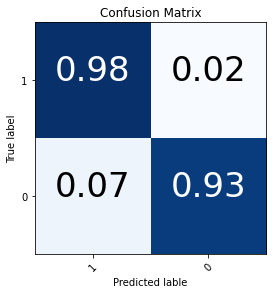

0.9579510022271714


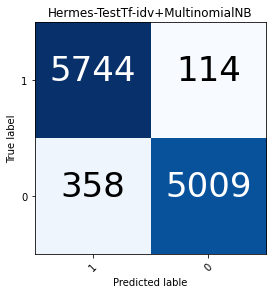

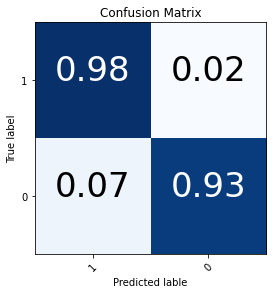

0.6872814126076943


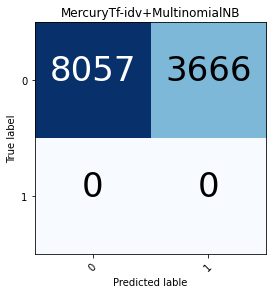

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


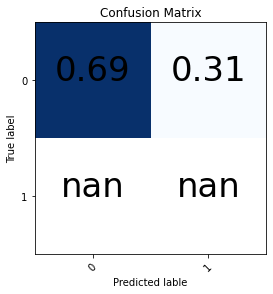

(1000, (1, 1), False, None, 2, 0.7, 0.1)
0.9556321088112137


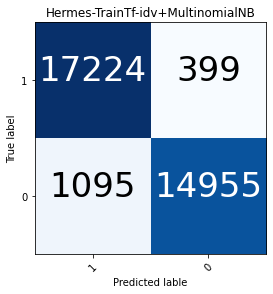

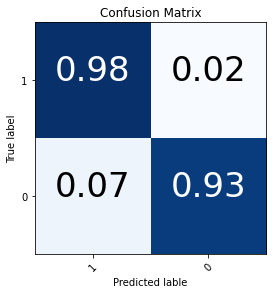

0.9580400890868597


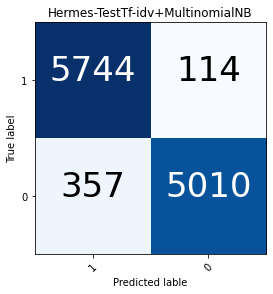

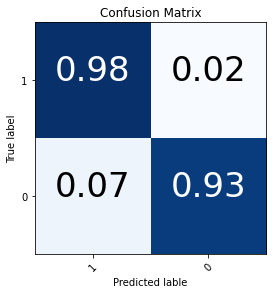

0.6863430862407234


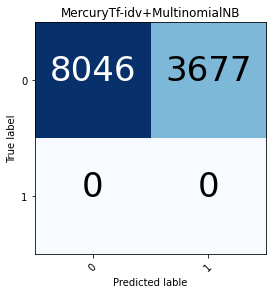

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


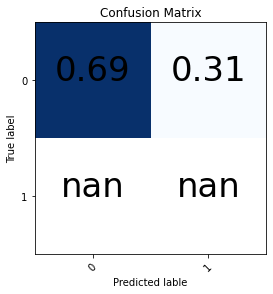

(1000, (1, 1), False, None, 2, 0.7, 0.5)
0.9558102931131768


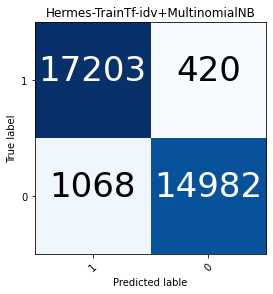

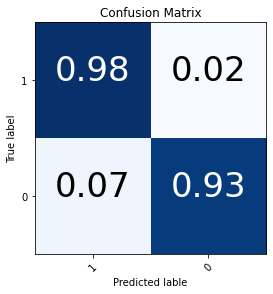

0.9580400890868597


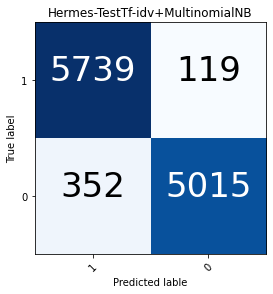

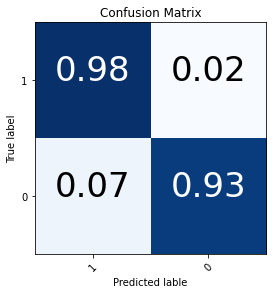

0.6746566578520856


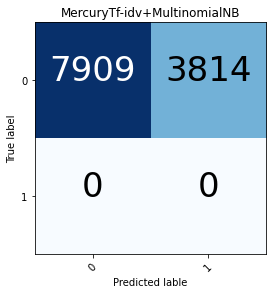

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


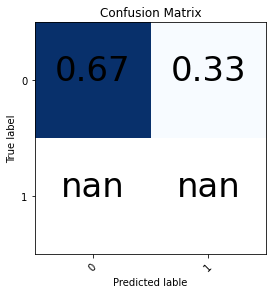

(1000, (1, 1), False, None, 2, 0.5, 0.001)


In [ ]:
tfidvVectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3), lowercase=False)
classifier = MultinomialNB(alpha=0.01)

maxFeatures = [1000, 100, 5000, 20000, 10000]
ngram_ranges = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
lowercases = [False, True]
stopwordsOptions = [None, stopwords]
options_minDF = [2, 5, 10, 15, 20]
options_maxDF = [1.0, 0.7, 0.5]
alphaOptions = [0.001, 0.01, 0.02, 0.05, 0.075, 0.1, 0.5]
zipParameters = list(itertools.product(
    maxFeatures, 
    ngram_ranges, 
    lowercases, 
    stopwordsOptions,
    options_minDF,
    options_maxDF,
    alphaOptions))

for parameterList in zipParameters:
    tfidvVectorizer = TfidfVectorizer(
        max_features=parameterList[0], 
        ngram_range=parameterList[1],
        lowercase=parameterList[2],
        stop_words=parameterList[3],
        min_df=parameterList[4],
        max_df=parameterList[5])
    classifier = MultinomialNB(alpha=parameterList[6])
    print(parameterList)
    transformClassify(tfidvVectorizer, classifier, "Tf-idv+MultinomialNB")
    

# LSTM 

In [4]:
batchSize = 128
countVectorizer = CountVectorizer(max_features=10000)
numberOfWords = len(allNewsData['title'].values)
corpus = removeNoisyData(allNewsData['title'].values, numberOfWords)
X = countVectorizer.fit_transform(corpus).toarray()
y = allNewsData['class'].values[:numberOfWords]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)
trainData = TensorDataset(torch.from_numpy(xTrain), torch.from_numpy(yTrain))
testData = TensorDataset(torch.from_numpy(xTest), torch.from_numpy(yTest))
trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=True)
validLoader = DataLoader(testData, batch_size=batchSize, shuffle=False, drop_last=True)
dataiter = iter(trainLoader)

class Model(torch.nn.Module):
    def __init__(self, vocabularySize, outputSize, embeddingDimensions, 
                 hiddenDimensions, numberOfLayers, dropProbability=0.5):
        super(Model, self).__init__()
        self.outputSize= outputSize
        self.numberOfLayers= numberOfLayers
        self.hiddenDimensions= hiddenDimensions
        
        self.embedding= torch.nn.Embedding(vocabularySize, embeddingDimensions)
        self.lstm= torch.nn.LSTM(embeddingDimensions, hiddenDimensions, numberOfLayers,
                          dropout=dropProbability, batch_first=True)
        self.dropout= torch.nn.Dropout(0.3)
        self.fc=torch.nn.Linear(hiddenDimensions, outputSize)
        self.sig=torch.nn.Sigmoid()
    def forward(self, x, hidden):
        batchSize = x.size(0)
        textEmbed = self.embedding(x)
        lstmOut, hidden = self.lstm(textEmbed, hidden)
        out = self.dropout(lstmOut)
        out = self.fc(out)
        sigmoidOut = self.sig(out)
        sigmoidOut = sigmoidOut.view(batchSize, -1)
        sigmoidOut = sigmoidOut[:, -1]
        return sigmoidOut, hidden
    def initHiddenParams(self, batchSize):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.numberOfLayers, batchSize, self.hiddenDimensions).zero_(),
                  weight.new(self.numberOfLayers, batchSize, self.hiddenDimensions).zero_())
        return hidden

#networkModel = Model(numberOfWords, 1, 64, 64, 2) -> 1h for 1000 len(train+valid)
networkModel = Model(numberOfWords, 1, 4, 1, 2)
print(networkModel)

Model(
  (embedding): Embedding(44898, 4)
  (lstm): LSTM(4, 1, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [5]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(networkModel.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, verbose=True)
clip = 5
epochs = 10
minLoss = numpy.inf

In [6]:
for currentEpoch in range(epochs):
    print("Current epoch: {}/{}...".format(currentEpoch + 1, epochs))
    
    trainLoss = 0.0
    validLoss = 0.0
    numberCorrect = 0
    hiddenState = networkModel.initHiddenParams(batchSize)
    networkModel.train()
    for inputs, labels in trainLoader:
        h = tuple([hidden.data for hidden in hiddenState])
        networkModel.zero_grad()
        output, h = networkModel(inputs, h) 
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(networkModel.parameters(), clip)
        optimizer.step()
        trainLoss += loss.item() 
    trainLoss = trainLoss / len(trainLoader.dataset)
    print("Train loss-> ", trainLoss)
    
    valH = networkModel.initHiddenParams(batchSize)
    networkModel.eval()
    for inputs, labels in validLoader:
        valH = tuple([hidden.data for hidden in valH])
        output, valH = networkModel(inputs, valH)
        pred = torch.round(output.squeeze())
        correctTensor = pred.eq(labels.float().view_as(pred))
        correct = numpy.squeeze(correctTensor.numpy())
        numberCorrect += numpy.sum(correct)
        loss = criterion(output.squeeze(), labels.float())
        validLoss += loss.item()
    validLoss = validLoss / len(validLoader.dataset)
    scheduler.step(validLoss)
    print("Val Loss: {:.6f}".format(validLoss),
          "Accuracy: {:.6f}".format(numberCorrect/len(validLoader.dataset)))
    if minLoss >= validLoss:
        minLoss = validLoss    

Current epoch: 1/10...
Train loss->  0.0058148834719726015
Val Loss: 0.005422 Accuracy: 0.474209
Current epoch: 2/10...
Train loss->  0.005516271190010605
Val Loss: 0.005386 Accuracy: 0.474209
Current epoch: 3/10...


KeyboardInterrupt: 

In [49]:
mercuryCorpus = removeNoisyData(englishMercuryDataNews['title'].values, len(englishMercuryDataNews['title'].values))
X_MercuryCorpus = countVectorizer.fit_transform(mercuryCorpus).toarray()
zeros = numpy.zeros(len(X_MercuryCorpus))
mercuryData = TensorDataset(torch.from_numpy(X_MercuryCorpus), torch.from_numpy(zeros))
mercuryLoader = DataLoader(mercuryData, batch_size=batchSize, shuffle=False, drop_last=True)

In [57]:
testLosses = []
numberIncorrect = 0
h = networkModel.initHiddenParams(batchSize)
networkModel.eval()
currentIteration = 0
for inputs, labels in mercuryLoader:
    h = tuple([each.data for each in h])
    output, h = networkModel(inputs, h)
    testLoss = criterion(output.squeeze(), labels.float())
    testLosses.append(testLoss.item())
    pred = torch.round(output.squeeze())
    correctTensor = pred.eq(labels.float().view_as(pred))
    correct = numpy.squeeze(correctTensor.numpy())
    numberIncorrect += numpy.sum(correct)
    currentIteration+=1
    if(currentIteration % 20 == 0):
        print("Test loss: {:.3f}".format(numpy.mean(testLosses)))
        print("Incorrect samples: ", numberIncorrect)
    

print("Test loss: {:.3f}".format(numpy.mean(testLosses)))
testAccuracy = numberIncorrect/len(mercuryLoader.dataset)
print("Test accuracy: {:.4f}%".format(testAccuracy*100))

Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrect samples:  0
Test loss: 9.924
Incorrec